In [ ]:
# Base Imports
import numpy as np
from google.colab import files
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importing existing model
from keras.models import load_model
trans_model = load_model("old_trained_keras_model.h5")

In [ ]:
# Seeding randomly. Prevents results from varying drastically
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/thumbs/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/thumbs/val.csv').readlines())
batch_size = 32 # Reduce if server throws an error

In [ ]:
# Func Defs: Image preprocessing

def cropResize(image, y, z):
    h, w = image.shape
    
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

def normalizeImage(image):
    # applying normalization
    return image/255.0

def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

def make2dFilter(x):
    return tuple([x]*2)

In [ ]:
def getBatchData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    print("debug", batch)
    return batch_data, batch_labels

In [ ]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        print("words are!",num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)
        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        print("I am here!")
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/thumbs/train'
val_path = '/content/drive/MyDrive/thumbs/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 260
# validation sequences = 37
# epochs = 10


In [ ]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 100, 100, 3]

# define image tensor size
img_tensor = getImgTensor(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]


In [ ]:
# Check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# Validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /content/drive/MyDrive/thumbs/train ; batch size = 32
words are! 8
debug 0
(32, 20, 100, 100, 3)
Source path =  /content/drive/MyDrive/thumbs/val ; batch size = 32
words are! 1
debug 0
(32, 20, 100, 100, 3)


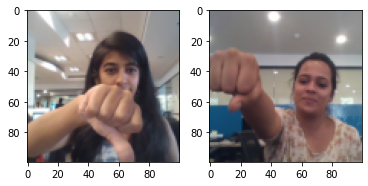

In [ ]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[16,10,:,:,:])   
ax[1].imshow(sample_val_batch_data[25,10,:,:,:])
plt.show()

In [ ]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

In [ ]:
# Model Imports
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

# callbacks_list = [checkpoint, LR]
callbacks_list = [LR]

In [ ]:
n_frames = 20
num_epochs = 60
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

In [ ]:
# Model Starts Here
def defineModel():
  model = Sequential([
      TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
      TimeDistributed(BatchNormalization()),
      TimeDistributed(MaxPooling2D(make2dFilter(2))),

      TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
      TimeDistributed(BatchNormalization()),
      TimeDistributed(MaxPooling2D(make2dFilter(2))),

      TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
      TimeDistributed(BatchNormalization()),
      TimeDistributed(MaxPooling2D(make2dFilter(2))),

      TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
      TimeDistributed(BatchNormalization()),
      TimeDistributed(MaxPooling2D(make2dFilter(2))),

      TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
      TimeDistributed(BatchNormalization()),
      TimeDistributed(MaxPooling2D(make2dFilter(2))),

      TimeDistributed(Flatten()),
      LSTM(256),
      Dropout(0.2),

      Dense(256, activation='relu'),
      Dropout(0.2),

      Dense(2, activation='softmax')
  ], name="conv_2d_lstm")
  model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  return model

In [ ]:
# Compile model as Transfer from previous gestures.
for i in range(5):
    trans_model.layers[i].trainable = False

for i in range(5,9):
    trans_model.layers[i].trainable = True

tm = trans_model.layers[8].output
tm = Dense(128)(tm)
tm = Dense(64)(tm)
tm = Dense(2,activation="softmax")(tm)

model = Model(inputs=trans_model.input,outputs=tm)

model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Compile and Obtain Base model.
model = defineModel()

In [ ]:
# Summary 
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1_input (InputLayer)  [(None, 120, 320, 1)]    0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 158, 32)       832       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 79, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 77, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 36, 64)        3692

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

debug 2
Epoch 1/60
5/9 [===============>..............] - ETA: 1:12 - loss: 1.1080 - categorical_accuracy: 0.4938debug 7
I am here!
debug 7
6/9 [===================>..........] - ETA: 53s - loss: 1.0298 - categorical_accuracy: 0.5365 words are! 65
debug 0
9/9 [==============================] - ETA: 0s - loss: 1.0109 - categorical_accuracy: 0.5392 Source path =  /content/drive/MyDrive/thumbs/val ; batch size = 32
words are! 1
debug 2
debug 0
I am here!
debug 0
words are! 7
debug 0
9/9 [==============================] - 119s 14s/step - loss: 1.0109 - categorical_accuracy: 0.5392 - val_loss: 1.9310 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/60
2/9 [=====>........................] - ETA: 15s - loss: 0.4931 - categorical_accuracy: 0.7500debug 4
debug 5
9/9 [==============================] - ETA: 0s - loss: 0.4904 - categorical_accuracy: 0.7500debug 11
debug 1
debug 2
debug 3
9/9 [==============================] - 23s 3s/step - loss: 0.4904 - categorical_accuracy: 0.7500 - v

In [ ]:
model.save('trained_keras_model.h5')

In [ ]:
plotModelHistory(model)